In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from flax import linen as nn
import sys, os
sys.path.insert(0, os.path.abspath(".."))
from modules.evaluation_functions.bnn_functions import *
from datetime import date
rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))

from modules.application_functions.finance_functions import *

In [2]:
target = "AAPL"
full_df = yf.download(target)
full_df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099192,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094017,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087117,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089273,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091861,73449600
...,...,...,...,...,...,...
2024-02-21,181.940002,182.889999,180.660004,182.320007,182.320007,41529700
2024-02-22,183.479996,184.960007,182.460007,184.369995,184.369995,52292200
2024-02-23,185.009995,185.039993,182.229996,182.520004,182.520004,45074500


In [3]:
errors=full_df.isna().any(axis=1)
errors[errors==True]

Series([], dtype: bool)

In [4]:
investment_horizon = 10
bound_volas = [2, 1.5]

full_df = yfinance_labeler(full_df, investment_horizon, bound_volas)
full_df

10890


,Open,High,Low,Close,Adj Close,Volume,vola,label
Date,,,,,,,,
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087117,105728000,0.015010,1
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089273,86441600,0.053096,1
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091861,73449600,0.052657,1
1980-12-19,0.126116,0.126674,0.126116,0.126116,0.097467,48630400,0.057076,1
1980-12-22,0.132254,0.132813,0.132254,0.132254,0.102211,37363200,0.053510,1
...,...,...,...,...,...,...,...,...
2024-02-06,186.860001,189.309998,186.770004,189.300003,189.058762,43490800,0.012625,0
2024-02-07,190.639999,191.050003,188.610001,189.410004,189.168625,53439000,0.012009,0
2024-02-08,189.389999,189.539993,187.350006,188.320007,188.080017,40962000,0.011569,0


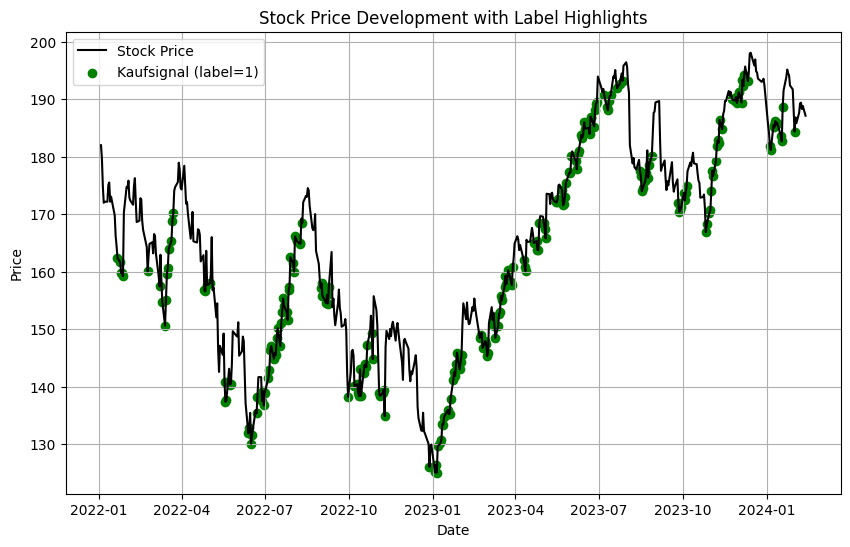

In [5]:
plot_df = full_df["2022-01-01":]

plt.figure(figsize=(10, 6))
plt.plot(plot_df.index, plot_df['Close'], label='Stock Price', color='black')

# Highlight points where 'label' is 1 in green
plt.scatter(plot_df[plot_df['label'] == 1].index, plot_df[plot_df['label'] == 1]['Close'], color='green', label='Kaufsignal (label=1)')

# Customize the plot
plt.title('Stock Price Development with Label Highlights')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [6]:
full_df = ichimoku(full_df)
full_df

,Open,High,Low,Close,Adj Close,Volume,vola,label,tenkan_sen_perc,kijun_sen_perc,...,tenkan_sen_higher_cloud,kijun_sen_higher_cloud,tenkan_sen_cloudDIFF,kijun_sen_cloudDIFF,positive_crossover,crossover,crossover_above,crossover_below,positive_crossover_cloud,crossover_cloud
Date,,,,,,,,,,,,,,,,,,,,,
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087117,105728000,0.015010,1,NaN,NaN,...,0,0,NaN,NaN,0,0,0,0,0,0
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089273,86441600,0.053096,1,NaN,NaN,...,0,0,NaN,NaN,0,0,0,0,0,0
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091861,73449600,0.052657,1,NaN,NaN,...,0,0,NaN,NaN,0,0,0,0,0,0
1980-12-19,0.126116,0.126674,0.126116,0.126116,0.097467,48630400,0.057076,1,NaN,NaN,...,0,0,NaN,NaN,0,0,0,0,0,0
1980-12-22,0.132254,0.132813,0.132254,0.132254,0.102211,37363200,0.053510,1,NaN,NaN,...,0,0,NaN,NaN,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-06,186.860001,189.309998,186.770004,189.300003,189.058762,43490800,0.012625,0,-0.000293,0.0,...,0,0,-6.379993,-6.324993,0,0,0,0,0,0
2024-02-07,190.639999,191.050003,188.610001,189.410004,189.168625,53439000,0.012009,0,-0.004021,0.0,...,0,0,-6.954998,-6.144993,0,0,0,0,0,0
2024-02-08,189.389999,189.539993,187.350006,188.320007,188.080017,40962000,0.011569,0,-0.006845,0.0,...,0,0,-5.544998,-3.454994,0,0,0,0,0,0


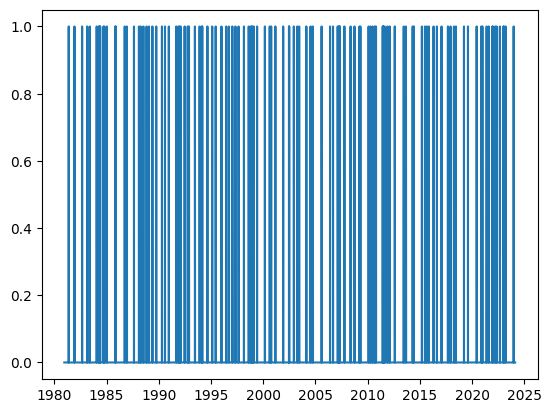

In [7]:
plt.plot(full_df.index, full_df['positive_crossover_cloud'])

In [8]:
full_df['close_pct'] = full_df['Close'].pct_change(1)
full_df['Volume_pct'] = full_df['Volume'].pct_change(1)

In [9]:
full_df.drop(['Open', 'Close', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)

In [10]:
# for col in list(full_df.columns):
#     full_df=create_lagged_columns(full_df, 20, col)

In [11]:
full_df

,vola,label,tenkan_sen_perc,kijun_sen_perc,senkou_span_a_perc,senkou_span_b_perc,tenkan_sen_higher_close,kijun_sen_higher_close,senkou_span_a_higher_close,senkou_span_b_higher_close,...,tenkan_sen_cloudDIFF,kijun_sen_cloudDIFF,positive_crossover,crossover,crossover_above,crossover_below,positive_crossover_cloud,crossover_cloud,close_pct,Volume_pct
Date,,,,,,,,,,,,,,,,,,,,,
1980-12-16,0.015010,1,NaN,NaN,NaN,NaN,0,0,0,0,...,NaN,NaN,0,0,0,0,0,0,NaN,NaN
1980-12-17,0.053096,1,NaN,NaN,NaN,NaN,0,0,0,0,...,NaN,NaN,0,0,0,0,0,0,0.024751,-0.182415
1980-12-18,0.052657,1,NaN,NaN,NaN,NaN,0,0,0,0,...,NaN,NaN,0,0,0,0,0,0,0.028992,-0.150298
1980-12-19,0.057076,1,NaN,NaN,NaN,NaN,0,0,0,0,...,NaN,NaN,0,0,0,0,0,0,0.061029,-0.337908
1980-12-22,0.053510,1,NaN,NaN,NaN,NaN,0,0,0,0,...,NaN,NaN,0,0,0,0,0,0,0.048670,-0.231690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-06,0.012625,0,-0.000293,0.0,-0.001569,0.0,0,0,1,0,...,-6.379993,-6.324993,0,0,0,0,0,0,0.008632,-0.375749
2024-02-07,0.012009,0,-0.004021,0.0,-0.000927,0.0,0,0,1,0,...,-6.954998,-6.144993,0,0,0,0,0,0,0.000581,0.228743
2024-02-08,0.011569,0,-0.006845,0.0,-0.013869,0.0,0,0,1,0,...,-5.544998,-3.454994,0,0,0,0,0,0,-0.005755,-0.233481


In [12]:
test_begin = "2018-01-01"
full_df.dropna(inplace=True)
train_df = full_df[:test_begin]
test_df = full_df[test_begin:]

In [13]:
Xs_train = train_df.drop('label', axis=1).values
Xs_test = test_df.drop('label', axis=1).values
Ys_train = train_df['label'].values
Ys_test = test_df['label'].values

In [14]:
# MLP params
hidden_layer_width = 10
n_hidden_layers = 5

class NN(nn.Module):
    n_hidden_layers: int
    layer_width: int

    @nn.compact
    def __call__(self, x):
        for i in range(self.n_hidden_layers):
            x = nn.Dense(features=self.layer_width)(x)
            x = nn.tanh(x)
        return nn.Dense(features=1)(x)


bnn = NN(n_hidden_layers, hidden_layer_width)

In [15]:
# probabilities_train = final_model.predict_proba(X_full)
# probabilities_train_positive = probabilities_train[:, 1]

# #Create a Precision/Recall curve for our training data
# precision_train, recall_train, pr_thresholds_train = precision_recall_curve(y_full, probabilities_train_positive)
# fscore_train = 2 * (precision_train * recall_train) / (precision_train + recall_train)

# #Find optimal thresh on PR curve train
# ix = np.argmax(fscore_train)
# optimal_threshold = pr_thresholds_train[ix]

In [16]:
rng_key, eval_key = jax.random.split(rng_key)


def fit_and_eval_single_mlp(key, X_train, Y_train, X_test):
    return fit_and_eval(
        key, bnn, logdensity_fn_of_bnn, X_train, Y_train, X_test, grid= None, num_steps=600,batch_size_particles = 50, batch_size_data = 64, num_particles=400
    )

Ys_pred_train, Ys_pred_test, _ = fit_and_eval_single_mlp(eval_key, Xs_train, Ys_train, Xs_test)

100%|██████████| 600/600 [00:59<00:00, 10.12it/s]


0.0
0.0


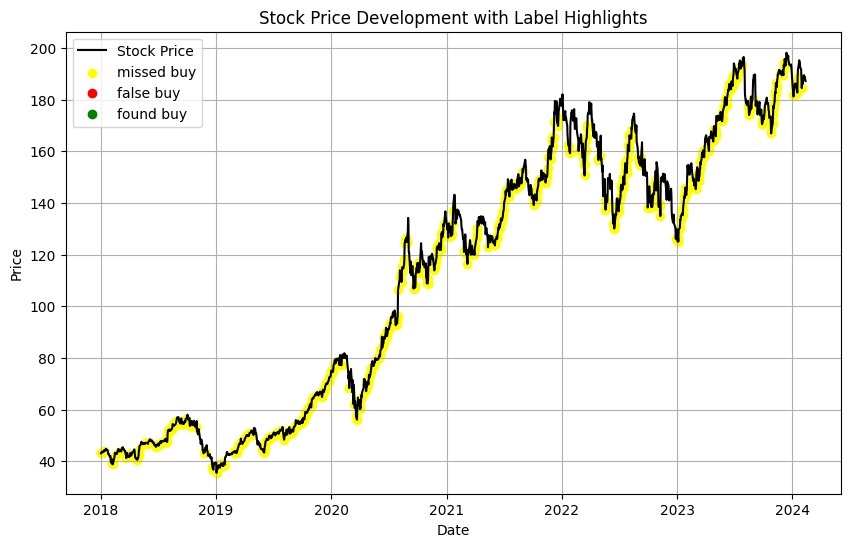

In [17]:
# Add Close prices back to df to see the visualization
prices = SPY_daily[test_begin:]["Close"]
plot_df = test_df.copy()
plot_df["Close"] = prices
plot_df["signal"] = Ys_pred_test.astype(int)

plt.figure(figsize=(10, 6))
plt.plot(plot_df.index, plot_df['Close'], label='Stock Price', color='black')

# Highlight points where 'label' is 1 in green
plt.scatter(plot_df[(plot_df['label'] == 1) & (plot_df['signal'] == 0)].index, plot_df[(plot_df['label'] == 1) & (plot_df['signal'] == 0)]['Close'], color='yellow', label='missed buy')
plt.scatter(plot_df[(plot_df['label'] == 0) & (plot_df['signal'] == 1)].index, plot_df[(plot_df['label'] == 0) & (plot_df['signal'] == 1)]['Close'], color='red', label='false buy')
plt.scatter(plot_df[(plot_df['label'] == 1) & (plot_df['signal'] == 1)].index, plot_df[(plot_df['label'] == 1) & (plot_df['signal'] == 1)]['Close'], color='green', label='found buy')

# Customize the plot
plt.title('Stock Price Development with Label Highlights')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [18]:
print(f"Train accuracy = {100 * jnp.mean(Ys_pred_train == Ys_train):.2f}%")
print(f"Test accuracy = {100 * jnp.mean(Ys_pred_test == Ys_test):.2f}%")

Train accuracy = 60.41%
Test accuracy = 53.38%
